In [1]:
from transformers import GPT2LMHeadModel, GPT2Tokenizer, GPT2ForQuestionAnswering
from DatasetChatbot import DatasetChatbot
from torch.optim import Adam
from torch.utils.data import DataLoader
import tqdm
import torch
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import GPUtil

# autoreload 
%load_ext autoreload
%autoreload 2


In [2]:
device = "cuda:1" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"

tokenizer = GPT2Tokenizer.from_pretrained("gpt2-large")
tokenizer.add_special_tokens({"pad_token": "<pad>"})
tokenizer.add_tokens(["<bot>: "])

model = GPT2LMHeadModel.from_pretrained("gpt2-large")
model.resize_token_embeddings(len(tokenizer))

model = model.to(device)

#model.load_state_dict(torch.load("model_state.pt"))

In [3]:
def train(trainData, valData, model, optim, device, epochs=10):
    train_losses = []
    val_losses = []

    for i in tqdm.tqdm(range(epochs)):
        model.train()
        epoch_loss = []
        for x in trainData:
            x = x.to(device)
            optim.zero_grad()
            loss = model(x, labels=x).loss
            epoch_loss.append(loss.item())
            loss.backward()
            optim.step()
        train_losses.append(sum(epoch_loss)/len(epoch_loss))
        model.eval()
        epoch_val_loss = []
        for x in valData:
            x = x.to(device)
            loss = model(x, labels=x).loss
            epoch_val_loss.append(loss.item())
        val_losses.append(sum(epoch_val_loss)/len(epoch_val_loss))
        print("Epoch: {}, Train loss: {}, Val loss: {}".format(i, train_losses[-1], val_losses[-1]))

    if(val_losses[-1] == min(val_losses)):
        torch.save(model.state_dict(), "model_state_2_large.pt")
    return train_losses, val_losses

In [4]:
path = "qa_heatpumps_2.csv"
chatData = DatasetChatbot(path, tokenizer)
trainData, testData = train_test_split(chatData, test_size=0.4, random_state=42)
valData, testData = train_test_split(testData, test_size=0.2, random_state=42)

trainLoader = DataLoader(trainData, batch_size=16, shuffle=True)
valLoader = DataLoader(valData, batch_size=16, shuffle=True)
testLoader = DataLoader(testData, batch_size=16, shuffle=True)

# Train: #

training .... 


 20%|██        | 1/5 [02:47<11:08, 167.16s/it]

Epoch: 0, Train loss: 1.5212624716226029, Val loss: 1.1608517816798254


 40%|████      | 2/5 [05:33<08:20, 166.95s/it]

Epoch: 1, Train loss: 0.9340287499705663, Val loss: 1.040009648894722


 60%|██████    | 3/5 [08:20<05:33, 166.75s/it]

Epoch: 2, Train loss: 0.6369060684211444, Val loss: 1.0151744243434884


 80%|████████  | 4/5 [11:06<02:46, 166.52s/it]

Epoch: 3, Train loss: 0.44486587795154486, Val loss: 1.0411944752051072


100%|██████████| 5/5 [13:53<00:00, 166.61s/it]

Epoch: 4, Train loss: 0.3185772413054958, Val loss: 1.0951467580754648


infer from model : 


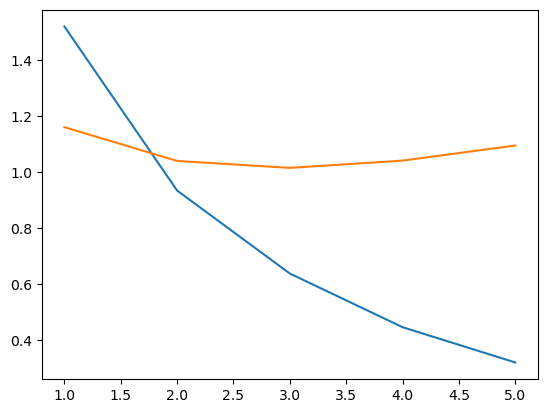

In [5]:
optim = Adam(model.parameters(), lr=1e-5)

print("training .... ")
train_losses, val_losses = train(trainData, valData, model, optim, device, epochs=5)
#plot(losses)
plt.plot(range(1, len(train_losses) + 1) ,train_losses)
plt.plot(range(1, len(val_losses) + 1) ,val_losses)


print("infer from model : ")

# Inference: #

In [6]:
def infer(model, tokenizer, device, text):
    model.eval()
    input = text
    input_ids = tokenizer(input, return_tensors="pt")['input_ids'].to(device)
    attention_mask = tokenizer(input, return_tensors="pt")['attention_mask'].to(device)
    output = model.generate(input_ids=input_ids, attention_mask=attention_mask, max_length=150,
                             num_beams=5, no_repeat_ngram_size=2, do_sample=True, 
                             top_k=50, top_p=0.95, temperature=1)
        
    return tokenizer.decode(output[0], skip_special_tokens=True)

In [7]:
model.load_state_dict(torch.load("model_state_2_large.pt"))

<All keys matched successfully>

In [8]:
df = pd.read_csv('qa_heatpumps_2.csv', sep=';')
questions = df['Question'].tolist()
#select 20 random questions
import random
random.seed(2)
random_questions = random.sample(questions, 30)


In [9]:
file_name = "qa_examples"
for question in random_questions:
    answer = infer(model, tokenizer, device, question)
    with open(file_name, 'a') as f:
        f.write("Question: " + question + "\n")
        f.write("Answer: " + answer + "\n")
        f.write("\n")
    

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end gene

In [ ]:
#let's iterate over the test set and see how the model performs
for X in testLoader:
    X = X.to(device)
    for x in X:
        qa = tokenizer.decode(x, skip_special_tokens=True)
        question = qa.split("<bot>:")[0]
        print("Question: ", question)
        output = infer(model, tokenizer, device, question)
        print("Output: ", output)
        answer = output.split("<bot>:")[1]
        print("Answer: ", answer)
        print("---------------------------------------------------------------")

In [ ]:
infer(model, tokenizer, device, "What is a heat pump?")

In [ ]:
for X in testLoader:
    X = X.to(device)
    bleu_scores = []
    for x in X:
        qa = tokenizer.decode(x, skip_special_tokens=True)
        question = qa.split("<bot>:")[0]
        answer = qa.split("<bot>:")[1].split(" ")
        output = infer(model, tokenizer, device, question)
        pred_answer = output.split("<bot>:")[1].split(" ")
        print(len(answer), len(pred_answer))
        bleu_scores.append(corpus_bleu(answer, pred_answer))